In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


In [2]:
# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        y_pred_log, feature_importance_all = classify.log_regression(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')
    


NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
y_pred_all: <class 'list'> feature_importance_all: <class 'list'>
logistic regression done
classified done


In [3]:
importance, sorted_features = feature_importance_all[0]
important_features = importance[importance > .15]
print(len(important_features))
top_features = sorted_features[:313]

print("Top 10 Important Features:", top_features)
print("Importance Scores:", importance[top_features])

313
Top 10 Important Features: [2206 1375 1278 2946 2709  232 1277 1618  195 2255 1364 1333 1631 3105
 1646 1553  312  225   51  285 3037 1310 1520 2814 2124  634 2235 2323
 2542  235 2261 2280  303  385  374 1596 1602 3077  121 2365   16 2708
 1350   57  887 1143  444  218 1312  706 2591 1704 1322 1313 2869  830
 2376 2297  383 1656  155  439 2482 1851  740 2370 1311 2592  434 1385
 2262   30 2272  183 2750 2571 1507 2642 2695 2993  167  281 2432 2984
 2493  435 2211 1036 2362 2585 1189 2358 2361 3025  231   61 2530 1325
 2244  523 2384 2954  606 2852  280 2525 2773 1782 1882 1283  714  188
  509 2300 2858 2437 3107  337 2329 1172  783  451 2696   32  813 3021
 1302 1358 1630 1958 1588 2212  463 1774 1930 2357 2375 2445 2572 1458
  538  408  700 1997 1559 2770  233 2178 2570  138  142 2137 2511 2547
 2066 3093 2301 1371 2516 1991 1661  318 2475  551 1664 3072  410 3038
 2706  109 2249 2385 3049 2615  624 1336 2456 1472  169 2562 1544 3018
 2888  549 1298 2831 2563 1768 2330   18   20 

In [8]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

# mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_percent_indices_1]
# mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_percent_indices_2]
# mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_r_1 = np.zeros(len(mean_activity_r_1))
sim_r_2 = np.zeros(len(mean_activity_r_2))

sim_r_1_random = np.zeros(len(mean_activity_r_1))

zero_indices = np.where(mean_activity_r_1 != 0)
    
# Normalize the reactivation mean activities using the difference vectors.
for i in range(0, len(mean_activity_r_1)):
    # nonzero_indices = np.where(mean_activity_r_1[i] != 0)
    top_n_percent_indices_r_1 = np.argsort(mean_activity_r_1[i])[-int(len(mean_activity_r_1[i]) * topn):]
    sim_r_1[i] = cos_sim(mean_activity_r_1[i][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)], mean_activity_cs_1_mean[1][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)])
    
    chosen_indices = np.random.randint(0, len(mean_activity_r_1[i]), 27)
    sim_r_1_random[i] = cos_sim(mean_activity_r_1[i][chosen_indices], mean_activity_cs_1_mean[1][chosen_indices])
    # sim_r_1[i] = cos_sim(mean_activity_rtopn_1[i], mean_activity_cstopn_1_late)
    # sim_r_1[i] = cos_sim(mean_activity_r_1[i], mean_activity_cs_1_mean[1])
    # sim_r_1[i] = np.dot(mean_activity_r_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_r_2)):
    # nonzero_indices = np.where(mean_activity_r_2[i] != 0)
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]
    sim_r_2[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)])
    # sim_r_2[i] = cos_sim(mean_activity_rtopn_2[i], mean_activity_cstopn_2_late)
    # sim_r_2[i] = cos_sim(mean_activity_r_2[i], mean_activity_cs_2_mean[1])
    # sim_r_2[i] = np.dot(mean_activity_r_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)



In [5]:
def compute_sign_changes(mean_activity_cs, trial_r):
    """
    Compute sign changes based on trial-to-trial differences and map them to reactivations.
    
    Parameters:
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - sign_changes: Array of sign changes mapped to reactivations (-1 or +1) for each neuron.
    """
    
    # Compute trial-to-trial differences
    trial_diff = np.diff(mean_activity_cs, axis=0)  # Shape: (trials-1, neurons)

    # Compute signs of trial differences
    trial_sign_changes = np.where(trial_diff > 0, 1, -1)  # Shape: (trials-1, neurons)

    # Map trial-level changes to reactivations, exclude last reactivation for shape match
    reactivation_sign_changes = trial_sign_changes[trial_r] 

    return reactivation_sign_changes

def clean_and_prepare_data(mean_activity_r, mean_activity_cs, trial_r):
    """
    Prepare predictors (X) and targets (y) for logistic regression ensuring correct trial-to-trial differences.
    
    Parameters:
    - mean_activity_r: Reactivation-level activity (shape: reactivations x neurons).
    - mean_activity_cs: Trial-level activity (shape: trials x neurons).
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,).
    
    Returns:
    - X_all: Combined predictors (reactivation activity) for sensory evoked response (shape: total_reactivations, neurons).
    - y_all: Combined targets (sign changes) for all neurons (shape: total_reactivations, neurons).
    """
    X_list = []  # Predictors for all neurons
    y_list = []  # Targets for all neurons
    
    # Compute targets for all neurons
    for neuron in range(mean_activity_cs_1.shape[1]):
        y_neuron = compute_sign_changes(mean_activity_cs[:, neuron], trial_r)
        y_list.append(y_neuron)
    
    # Prepare predictors for the subset of neurons
    for neuron in range(mean_activity_r.shape[1]):
        # Adjust reactivation activity by subtracting the SER activity
        X_neuron = mean_activity_r[:, neuron] - mean_activity_cs[trial_r, neuron]
        X_list.append(X_neuron)
    
    # Stack all predictors and targets
    X_all = np.column_stack(X_list)  # Shape: (total_reactivations, subset_neurons)
    y_all = np.column_stack(y_list)  # Shape: (total_reactivations, total_neurons)
        
    return X_all, y_all

X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

# Combine the datasets
X_all = np.concatenate([X_cs_1, X_cs_2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

print(X_cs_1.shape, y_cs_1_clean.shape)

# Sanity check the processed targets
unique_cs_1, counts_cs_1 = np.unique(y_cs_1_clean, return_counts=True)
unique_cs_2, counts_cs_2 = np.unique(y_cs_2_clean, return_counts=True)

print("Processed Targets for CS_1:")
print(dict(zip(unique_cs_1, counts_cs_1)))
print("\nProcessed Targets for CS_2:")
print(dict(zip(unique_cs_2, counts_cs_2)))

(139, 3124) (139, 3124)
Processed Targets for CS_1:
{-1: 216563, 1: 217673}

Processed Targets for CS_2:
{-1: 173997, 1: 172767}


X_all shape: (250, 3124), y_all shape: (250, 3124)

=== Cross-Validation Summary ===
Accuracy:  0.858 ± 0.047
Precision: 0.858
Recall:    0.861
F1-score:  0.856


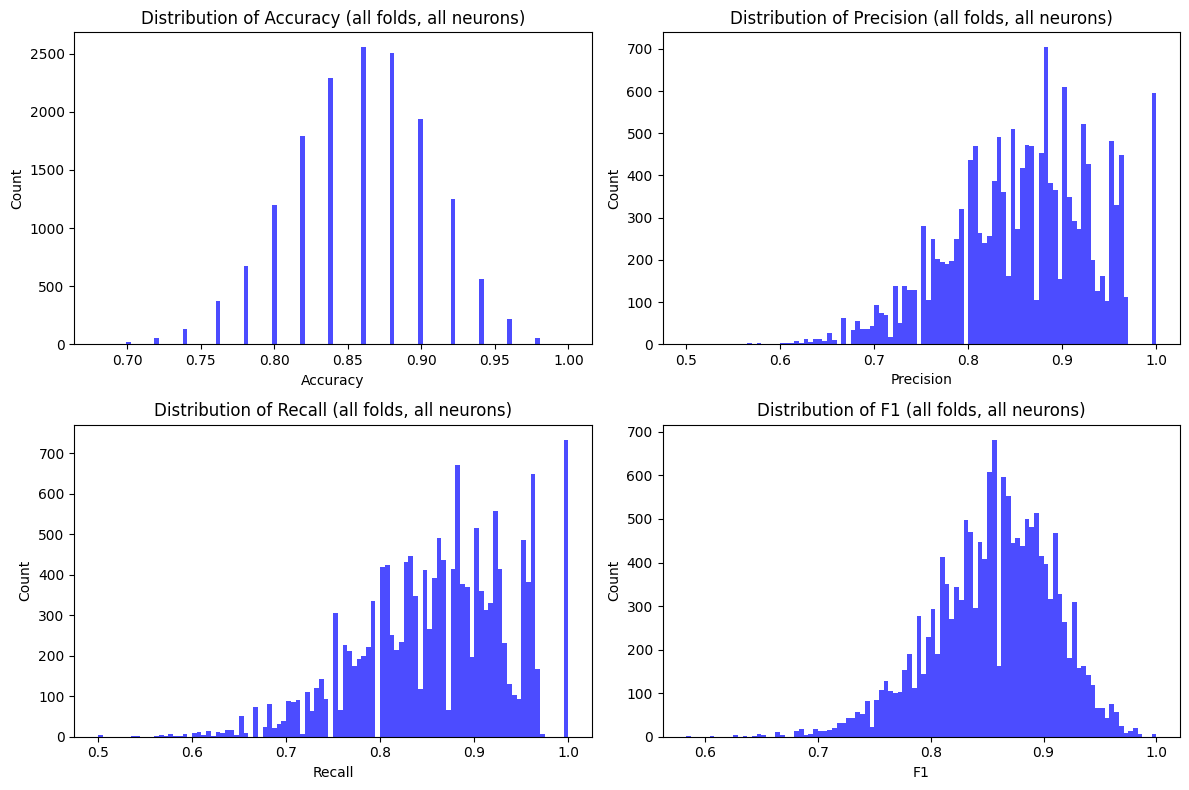

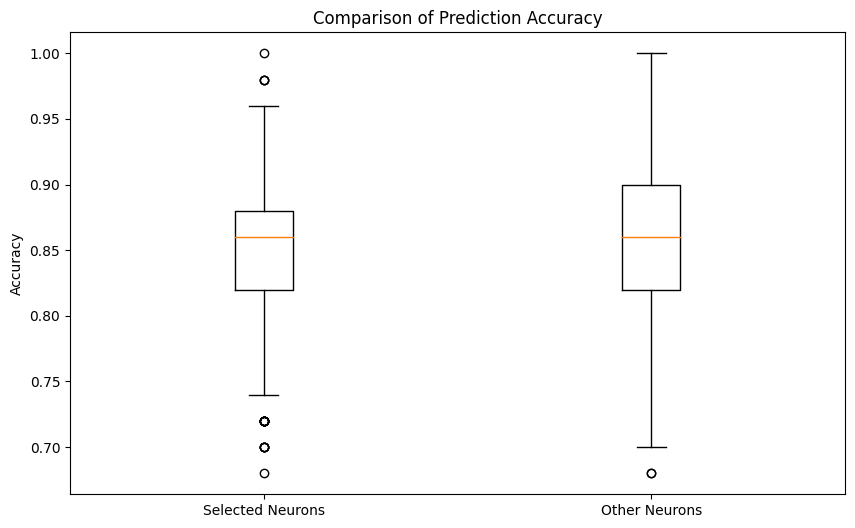

Selected Neurons Accuracy:
Mean: 0.85430, Std: 0.04684

Other Neurons Accuracy:
Mean: 0.85896, Std: 0.04718

T-test Results: t-statistic = -4.75, p-value = 2.09e-06


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from joblib import Parallel, delayed
from scipy.stats import ttest_ind



def evaluate_fold(model, X_train, X_test, y_train, y_test):
    """Trains the model and evaluates metrics for a single CV fold."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute metrics for each output (neuron)
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    for neuron_idx in range(y_test.shape[1]):
        y_test_n = y_test[:, neuron_idx]
        y_pred_n = y_pred[:, neuron_idx]

        fold_accuracies.append(accuracy_score(y_test_n, y_pred_n))
        fold_precisions.append(precision_score(y_test_n, y_pred_n, zero_division=0))
        fold_recalls.append(recall_score(y_test_n, y_pred_n, zero_division=0))
        fold_f1s.append(f1_score(y_test_n, y_pred_n, zero_division=0))

    return fold_accuracies, fold_precisions, fold_recalls, fold_f1s

def LR_model(X_all, y_all, selected_neurons):
    print(f"X_all shape: {X_all.shape}, y_all shape: {y_all.shape}")

    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Model initialization
    base_model = LogisticRegression(max_iter=1000, random_state=42, solver="lbfgs", 
                                    penalty="l2", class_weight="balanced")
    model_cv = MultiOutputClassifier(base_model)

    # Aggregate results
    all_results = Parallel(n_jobs=-1)(delayed(evaluate_fold)(
        model_cv, 
        X_all[train_idx], X_all[test_idx], 
        y_all[train_idx], y_all[test_idx]
    ) for train_idx, test_idx in kf.split(X_all))

    # Unpack results
    all_accuracies, all_precisions, all_recalls, all_f1s = zip(*all_results)
    all_accuracies = np.concatenate(all_accuracies)
    all_precisions = np.concatenate(all_precisions)
    all_recalls = np.concatenate(all_recalls)
    all_f1s = np.concatenate(all_f1s)

    # Summary
    print("\n=== Cross-Validation Summary ===")
    print(f"Accuracy:  {np.mean(all_accuracies):.3f} ± {np.std(all_accuracies):.3f}")
    print(f"Precision: {np.mean(all_precisions):.3f}")
    print(f"Recall:    {np.mean(all_recalls):.3f}")
    print(f"F1-score:  {np.mean(all_f1s):.3f}")

    metrics_dict = {
    "Accuracy": all_accuracies,
    "Precision": all_precisions,
    "Recall": all_recalls,
    "F1": all_f1s
    }

    plt.figure(figsize=(12, 8))
    for i, (metric_name, values) in enumerate(metrics_dict.items()):
        plt.subplot(2, 2, i+1)
        plt.hist(values, bins=100, alpha=0.7, color='b')
        plt.title(f"Distribution of {metric_name} (all folds, all neurons)")
        plt.xlabel(metric_name)
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

    # Calculate accuracy for each neuron
    accuracies = np.array(all_accuracies).reshape(-1, y_all.shape[1])

    # Separate metrics for selected neurons and other neurons
    selected_accuracies = accuracies[:, selected_neurons].flatten()
    other_accuracies = np.delete(accuracies, selected_neurons, axis=1).flatten()

    # Visualization: Boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot([selected_accuracies, other_accuracies], labels=['Selected Neurons', 'Other Neurons'])
    plt.title('Comparison of Prediction Accuracy')
    plt.ylabel('Accuracy')
    plt.show()

    # Summary statistics
    print("Selected Neurons Accuracy:")
    print(f"Mean: {np.mean(selected_accuracies):.5f}, Std: {np.std(selected_accuracies):.5f}")
    print("\nOther Neurons Accuracy:")
    print(f"Mean: {np.mean(other_accuracies):.5f}, Std: {np.std(other_accuracies):.5f}")

    # Statistical Test: T-test
    t_stat, p_val = ttest_ind(selected_accuracies, other_accuracies, equal_var=False)
    print(f"\nT-test Results: t-statistic = {t_stat:.2f}, p-value = {p_val:.2e}")

LR_model(X_all, y_all, top_neurons_learn)

In [71]:
print(idx)

{'cs_1':       mean_fluorescence
152            0.201930
2886           0.195724
4687           0.187626
147            0.179522
66             0.161705
...                 ...
3155           0.006239
209            0.005911
289            0.005789
3148           0.005599
93             0.003378

[2546 rows x 1 columns], 'cs_2':       mean_fluorescence
59             0.227315
2889           0.210854
112            0.181760
3124           0.178220
3417           0.166887
...                 ...
3870           0.007046
113            0.006707
151            0.005661
4755           0.004765
2867           0.000433

[2277 rows x 1 columns], 'cs_1_df':       mean_fluorescence
2886           0.182647
152            0.177400
147            0.163690
3039           0.149386
66             0.145058
...                 ...
692           -0.111874
3486          -0.112425
331           -0.119068
3417          -0.123590
59            -0.205347

[2546 rows x 1 columns], 'cs_2_df':       mean_fluoresc

In [98]:
def analyze_significant_neurons(mean_activity_r, trials):
    """
    Analyze significantly active neurons across reactivation events.

    Parameters:
    - mean_activity_r: Reactivation-level activity (shape: reactivations x neurons).
    - trials: Number of reactivations to analyze.
    - k: Threshold multiplier for standard deviation to determine significance.

    Returns:
    - significant_neurons_list: A list of lists, each containing the indices of significantly active neurons per reactivation.
    - similarity_matrix: A 2D matrix showing the Jaccard similarity between reactivation events.
    """
    reactivations, neurons = mean_activity_r.shape
    significant_neurons_list = []
    
    # Identify significantly active neurons for each reactivation
    for i in range(trials):
        threshold = np.percentile(mean_activity_r[i], 90)
        significant_neurons = np.where(mean_activity_r[i] > threshold)[0]

        # Identify significant neurons without sorting
        significant_neurons = np.where(mean_activity_r[i] > threshold)[0]  
        significant_neurons_list.append(significant_neurons)  

        # Print the number of significant neurons for this reactivation
        #print(f"Reactivation {i + 1}: {len(significant_neurons)} significant neurons")

    consecutive_overlap_counts = []

    for i in range(trials - 1):  # Iterate up to the second-to-last reactivation
        # Calculate overlap for consecutive reactivations
        overlap_count = len(np.intersect1d(significant_neurons_list[i], significant_neurons_list[i + 1]))
        consecutive_overlap_counts.append(overlap_count)
        print(f"Overlap between reactivation {i + 1} and {i + 2}: {overlap_count} / {len(significant_neurons_list[i + 1])} neurons")

    # Print summary
    print("\nSummary of Similarity:")
    avg_similarity = np.mean(consecutive_overlap_counts)  # Exclude diagonal
    print(f"Average similarity across reactivations: {avg_similarity:.2f}")

    return significant_neurons_list


In [ ]:
def plot_significant_neurons(significant_neurons_list, total_neurons):
    """
    Plot a reactivation x neuron grid where each square is green if the neuron
    is significantly active during a reactivation, and red otherwise.
    
    Parameters:
    - significant_neurons_list: List of sets containing significantly active neuron indices per reactivation.
    - total_neurons: Total number of neurons in the dataset.
    """
    reactivations = len(significant_neurons_list)
    
    # Create a binary matrix for visualization
    activity_matrix = np.zeros((reactivations, total_neurons))
    
    for i, significant_neurons in enumerate(significant_neurons_list):
        activity_matrix[i, list(significant_neurons)] = 1  # Mark active neurons as 1
    
    # Plot the activity matrix
    plt.figure(figsize=(12, 8))
    plt.imshow(activity_matrix, cmap='RdYlGn', aspect='auto')
    plt.colorbar(label='Significant Activity (1 = Active, 0 = Not Active)')
    plt.axhline(3)
    plt.axhline(6)
    plt.axhline(8)
    plt.axhline(9)
    plt.axhline(11)
    plt.axhline(11)
    plt.axhline(12)
    plt.axhline(14)
    plt.axhline(16)
    plt.axhline(18)
    plt.axhline(20)
    plt.xlabel('Neurons')
    plt.ylabel('Reactivations')
    plt.title('Significant Neuron Activity Across Reactivations')
    plt.show()



In [92]:
for k, v in significant_neurons_list_r1:
    print(k)

ValueError: too many values to unpack (expected 2)

Overlap between reactivation 1 and 2: 10 / 63 neurons
Overlap between reactivation 2 and 3: 2 / 63 neurons
Overlap between reactivation 3 and 4: 2 / 63 neurons
Overlap between reactivation 4 and 5: 10 / 63 neurons
Overlap between reactivation 5 and 6: 8 / 63 neurons
Overlap between reactivation 6 and 7: 7 / 63 neurons
Overlap between reactivation 7 and 8: 15 / 63 neurons
Overlap between reactivation 8 and 9: 14 / 63 neurons
Overlap between reactivation 9 and 10: 1 / 63 neurons
Overlap between reactivation 10 and 11: 7 / 63 neurons
Overlap between reactivation 11 and 12: 5 / 63 neurons
Overlap between reactivation 12 and 13: 2 / 63 neurons
Overlap between reactivation 13 and 14: 8 / 63 neurons
Overlap between reactivation 14 and 15: 5 / 63 neurons
Overlap between reactivation 15 and 16: 8 / 63 neurons
Overlap between reactivation 16 and 17: 3 / 63 neurons
Overlap between reactivation 17 and 18: 5 / 63 neurons
Overlap between reactivation 18 and 19: 5 / 63 neurons
Overlap between reactiv

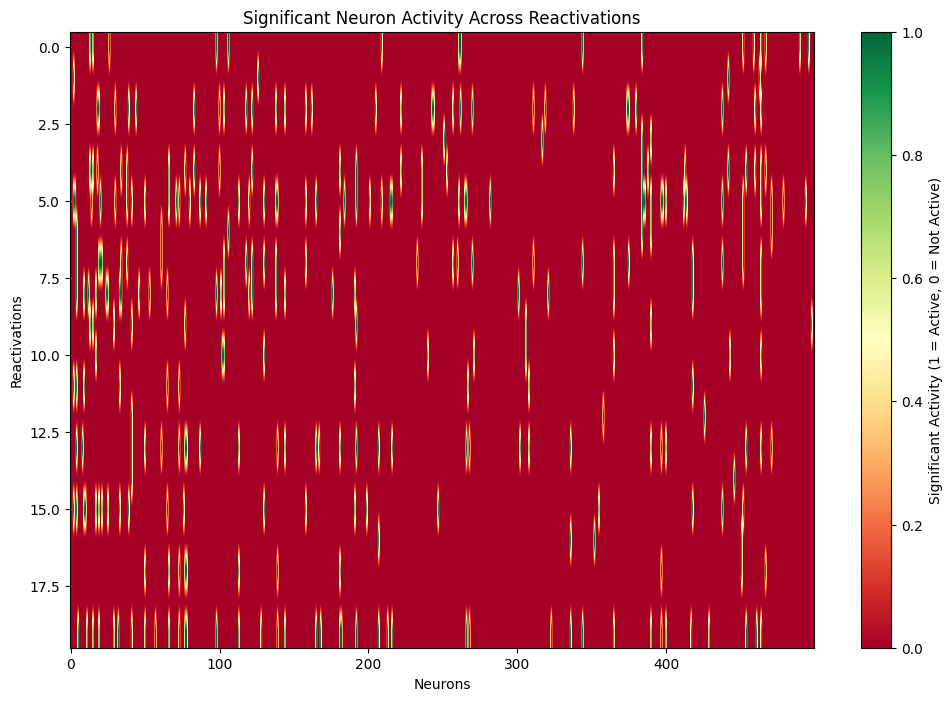

In [94]:
significant_neurons_list_r1 = analyze_significant_neurons(mean_activity_r_1, trials=20)#mean_activity_r_1.shape[0])
plot_significant_neurons([v[v<500] for v in significant_neurons_list_r1], total_neurons=500)


Overlap between reactivation 1 and 2: 72 / 313 neurons
Overlap between reactivation 2 and 3: 82 / 313 neurons
Overlap between reactivation 3 and 4: 59 / 313 neurons
Overlap between reactivation 4 and 5: 67 / 313 neurons
Overlap between reactivation 5 and 6: 53 / 313 neurons
Overlap between reactivation 6 and 7: 65 / 313 neurons
Overlap between reactivation 7 and 8: 48 / 313 neurons
Overlap between reactivation 8 and 9: 138 / 313 neurons
Overlap between reactivation 9 and 10: 43 / 313 neurons
Overlap between reactivation 10 and 11: 46 / 313 neurons
Overlap between reactivation 11 and 12: 45 / 313 neurons
Overlap between reactivation 12 and 13: 55 / 313 neurons
Overlap between reactivation 13 and 14: 46 / 313 neurons
Overlap between reactivation 14 and 15: 34 / 313 neurons
Overlap between reactivation 15 and 16: 64 / 313 neurons
Overlap between reactivation 16 and 17: 59 / 313 neurons
Overlap between reactivation 17 and 18: 69 / 313 neurons
Overlap between reactivation 18 and 19: 57 / 31

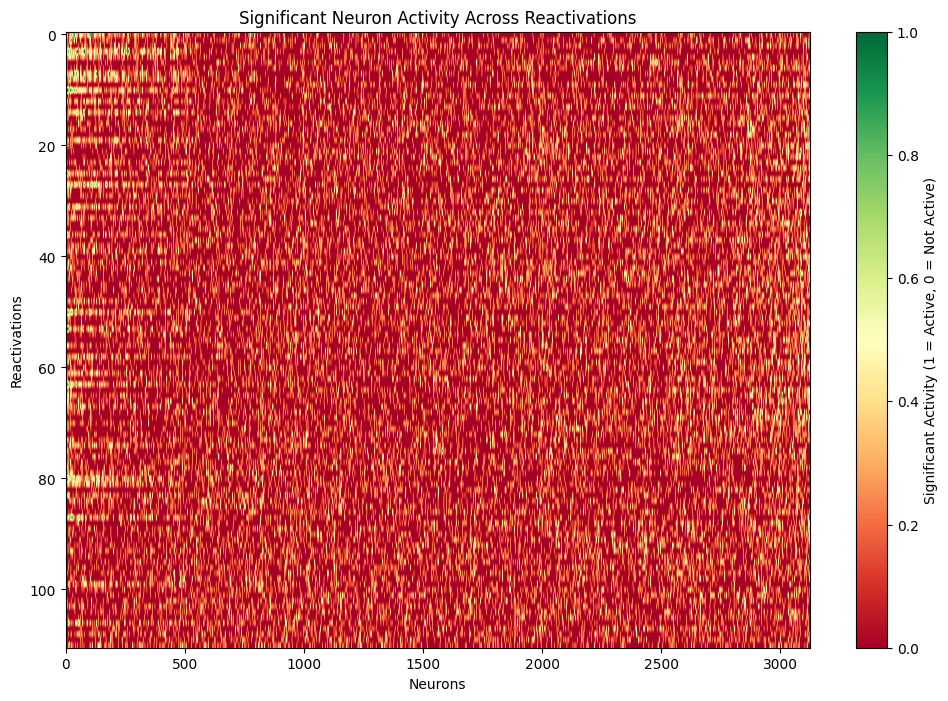

In [99]:
significant_neurons_list_r2 = analyze_significant_neurons(mean_activity_r_2, trials=mean_activity_r_2.shape[0])
plot_significant_neurons(significant_neurons_list_r2, total_neurons=mean_activity_r_2.shape[1])


In [102]:
print(trial_r_1)

[1, 1, 1, 2, 2, 2, 3, 3, 4, 5, 5, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21, 21, 21, 23, 24, 25, 25, 26, 26, 27, 28, 29, 29, 29, 30, 30, 30, 30, 31, 33, 34, 34, 34, 35, 36, 37, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 44, 44, 45, 45, 46, 47, 48, 50, 51, 52, 52, 52, 53, 53, 54, 54, 54, 55, 55, 55, 55, 56, 57, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 60, 60, 61, 61, 61, 62, 62, 62, 62, 63, 63, 64, 64, 64, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66]


Overlap between reactivation 1 and 2: 124 / 313 neurons
Overlap between reactivation 2 and 3: 118 / 313 neurons
Overlap between reactivation 3 and 4: 132 / 313 neurons
Overlap between reactivation 4 and 5: 94 / 313 neurons
Overlap between reactivation 5 and 6: 98 / 313 neurons
Overlap between reactivation 6 and 7: 123 / 313 neurons
Overlap between reactivation 7 and 8: 98 / 313 neurons
Overlap between reactivation 8 and 9: 90 / 313 neurons
Overlap between reactivation 9 and 10: 101 / 313 neurons
Overlap between reactivation 10 and 11: 81 / 313 neurons
Overlap between reactivation 11 and 12: 105 / 313 neurons
Overlap between reactivation 12 and 13: 102 / 313 neurons
Overlap between reactivation 13 and 14: 91 / 313 neurons
Overlap between reactivation 14 and 15: 66 / 313 neurons
Overlap between reactivation 15 and 16: 108 / 313 neurons
Overlap between reactivation 16 and 17: 76 / 313 neurons
Overlap between reactivation 17 and 18: 85 / 313 neurons
Overlap between reactivation 18 and 19: 

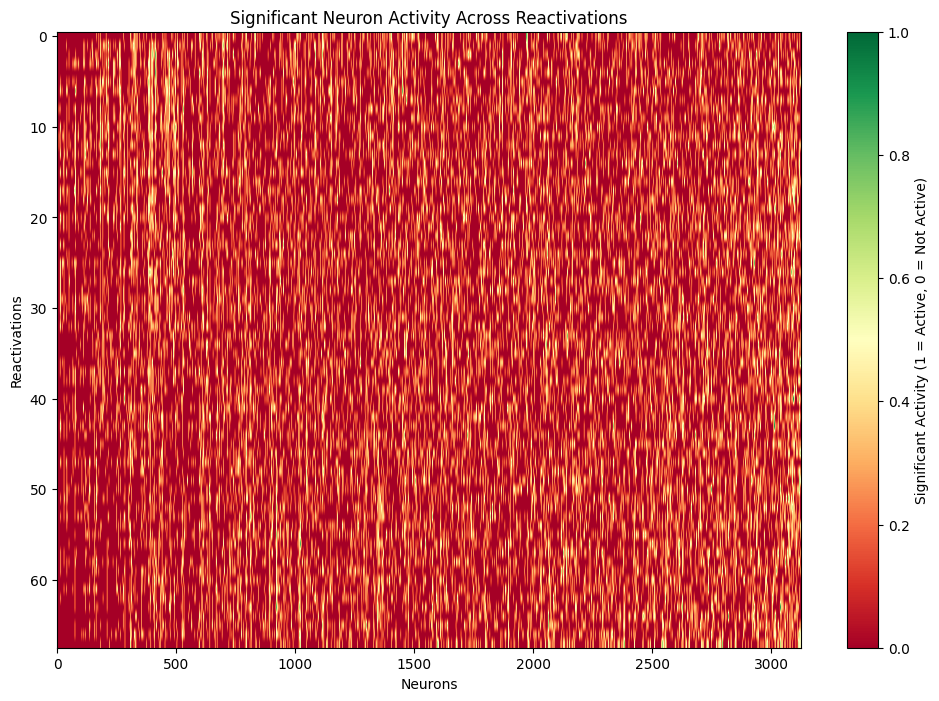

In [75]:
significant_neurons_list_cs1 = analyze_significant_neurons(mean_activity_cs_1, trials=mean_activity_cs_1.shape[0])
plot_significant_neurons(significant_neurons_list_cs1, total_neurons=mean_activity_cs_1.shape[1])

Overlap between reactivation 1 and 2: 4 / 10 neurons
Overlap between reactivation 2 and 3: 2 / 10 neurons
Overlap between reactivation 3 and 4: 4 / 10 neurons
Overlap between reactivation 4 and 5: 4 / 10 neurons
Overlap between reactivation 5 and 6: 3 / 10 neurons
Overlap between reactivation 6 and 7: 6 / 10 neurons
Overlap between reactivation 7 and 8: 5 / 10 neurons
Overlap between reactivation 8 and 9: 3 / 10 neurons
Overlap between reactivation 9 and 10: 6 / 10 neurons
Overlap between reactivation 10 and 11: 8 / 10 neurons
Overlap between reactivation 11 and 12: 8 / 10 neurons
Overlap between reactivation 12 and 13: 5 / 10 neurons
Overlap between reactivation 13 and 14: 4 / 10 neurons
Overlap between reactivation 14 and 15: 1 / 10 neurons
Overlap between reactivation 15 and 16: 3 / 10 neurons
Overlap between reactivation 16 and 17: 2 / 10 neurons
Overlap between reactivation 17 and 18: 4 / 10 neurons
Overlap between reactivation 18 and 19: 4 / 10 neurons
Overlap between reactivatio

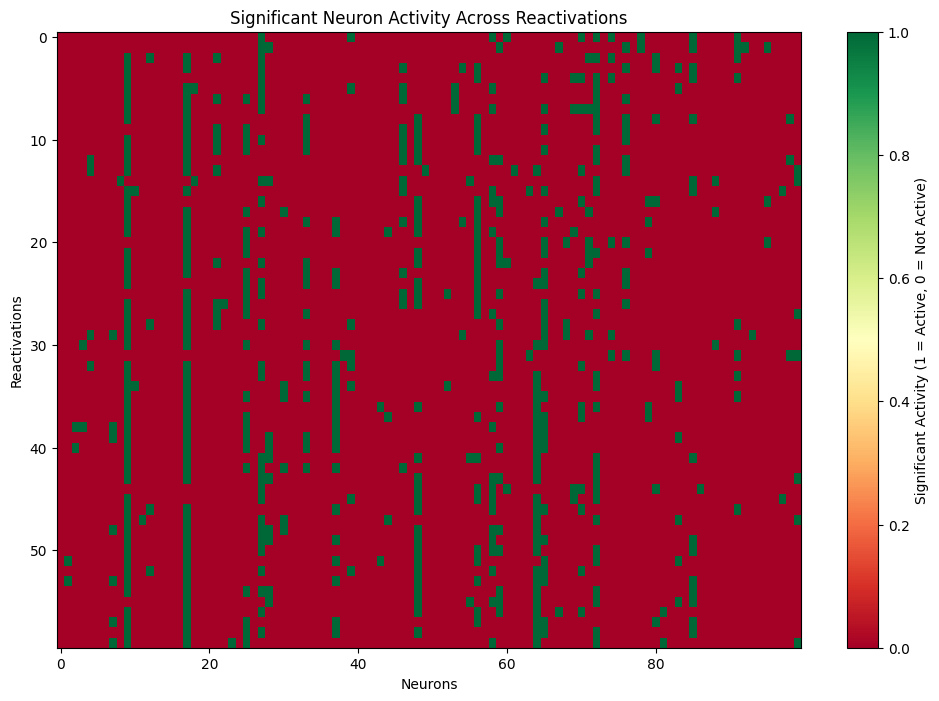

In [81]:
significant_neurons_list_cs2 = analyze_significant_neurons(mean_activity_cs_2[:, :100], trials=60)
plot_significant_neurons(significant_neurons_list_cs2, total_neurons=100)


Overlap between reactivation 1 and 2: 281 / 625 neurons
Overlap between reactivation 2 and 3: 268 / 625 neurons
Overlap between reactivation 3 and 4: 287 / 625 neurons
Overlap between reactivation 4 and 5: 259 / 625 neurons
Overlap between reactivation 5 and 6: 260 / 625 neurons
Overlap between reactivation 6 and 7: 282 / 625 neurons
Overlap between reactivation 7 and 8: 240 / 625 neurons
Overlap between reactivation 8 and 9: 239 / 625 neurons
Overlap between reactivation 9 and 10: 243 / 625 neurons
Overlap between reactivation 10 and 11: 210 / 625 neurons

Summary of Similarity:
Average similarity across reactivations: 256.90


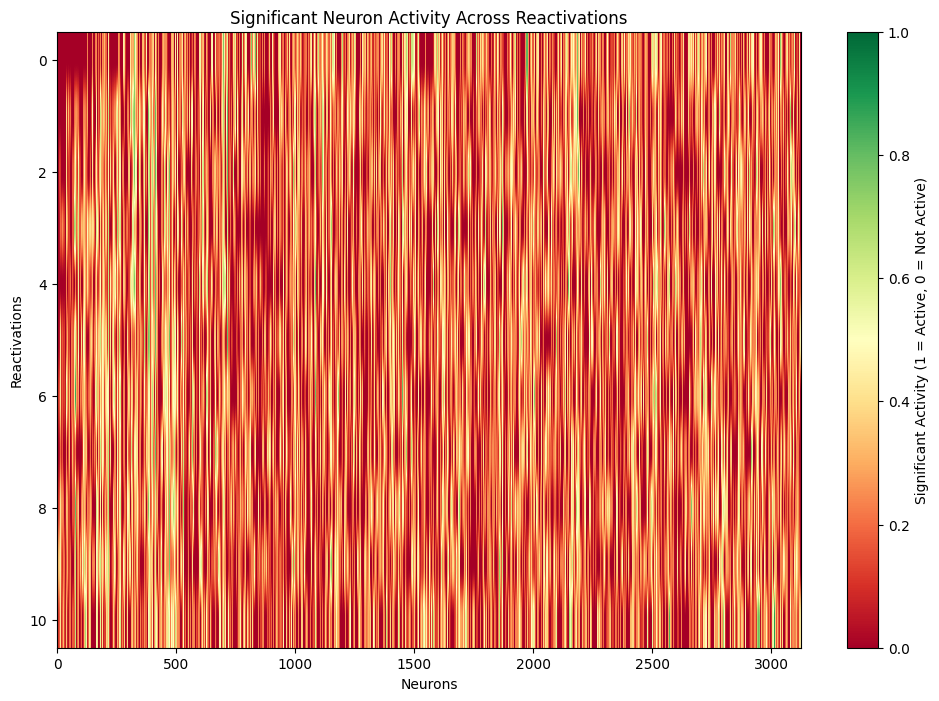

In [20]:
significant_neurons_list_cs1_start = analyze_significant_neurons(mean_activity_cs_1, trials=11)
plot_significant_neurons(significant_neurons_list_cs1_start, total_neurons=mean_activity_r_1.shape[1])


In [21]:
def compute_unique_neurons(list_of_neurons):
    unique_neurons = np.unique(list_of_neurons)
    unique_count = len(unique_neurons)
    print(f"unique neuron indices: {unique_neurons}")
    print(f"number of unqiue neuron indices: {unique_count}")

compute_unique_neurons(significant_neurons_list_cs1)
compute_unique_neurons(significant_neurons_list_r1)

compute_unique_neurons(significant_neurons_list_cs2)
compute_unique_neurons(significant_neurons_list_r2)

def compute_unique_neurons_across(list_of_neurons1, list_of_neurons2):
    combined_list = np.concatenate((list_of_neurons1, list_of_neurons2))
    unique_neurons = np.unique(combined_list)
    unique_count = len(unique_neurons)
    print(f"unique neuron indices: {unique_neurons}")
    print(f"number of unqiue neuron indices: {unique_count}")

compute_unique_neurons_across(significant_neurons_list_cs1, significant_neurons_list_cs2)
compute_unique_neurons_across(significant_neurons_list_r1, significant_neurons_list_r2)

compute_unique_neurons_across(significant_neurons_list_cs1, significant_neurons_list_r1)
compute_unique_neurons_across(significant_neurons_list_cs2, significant_neurons_list_r2)


    

unique neuron indices: [   0    3    4 ... 3121 3122 3123]
number of unqiue neuron indices: 3016
unique neuron indices: [   0    1    2 ... 3121 3122 3123]
number of unqiue neuron indices: 3124
unique neuron indices: [   0    1    2 ... 3121 3122 3123]
number of unqiue neuron indices: 2971
unique neuron indices: [   0    1    2 ... 3121 3122 3123]
number of unqiue neuron indices: 3124
unique neuron indices: [   0    1    2 ... 3121 3122 3123]
number of unqiue neuron indices: 3123
unique neuron indices: [   0    1    2 ... 3121 3122 3123]
number of unqiue neuron indices: 3124
unique neuron indices: [   0    1    2 ... 3121 3122 3123]
number of unqiue neuron indices: 3124
unique neuron indices: [   0    1    2 ... 3121 3122 3123]
number of unqiue neuron indices: 3124


Overlap between reactivation 1 and 2: 26 / 63 neurons
Overlap between reactivation 2 and 3: 17 / 63 neurons
Overlap between reactivation 3 and 4: 13 / 63 neurons
Overlap between reactivation 4 and 5: 14 / 63 neurons
Overlap between reactivation 5 and 6: 20 / 63 neurons
Overlap between reactivation 6 and 7: 15 / 63 neurons
Overlap between reactivation 7 and 8: 20 / 63 neurons
Overlap between reactivation 8 and 9: 29 / 63 neurons
Overlap between reactivation 9 and 10: 19 / 63 neurons
Overlap between reactivation 10 and 11: 17 / 63 neurons
Overlap between reactivation 11 and 12: 17 / 63 neurons
Overlap between reactivation 12 and 13: 5 / 63 neurons
Overlap between reactivation 13 and 14: 16 / 63 neurons
Overlap between reactivation 14 and 15: 9 / 63 neurons
Overlap between reactivation 15 and 16: 11 / 63 neurons
Overlap between reactivation 16 and 17: 5 / 63 neurons
Overlap between reactivation 17 and 18: 16 / 63 neurons
Overlap between reactivation 18 and 19: 18 / 63 neurons
Overlap betw

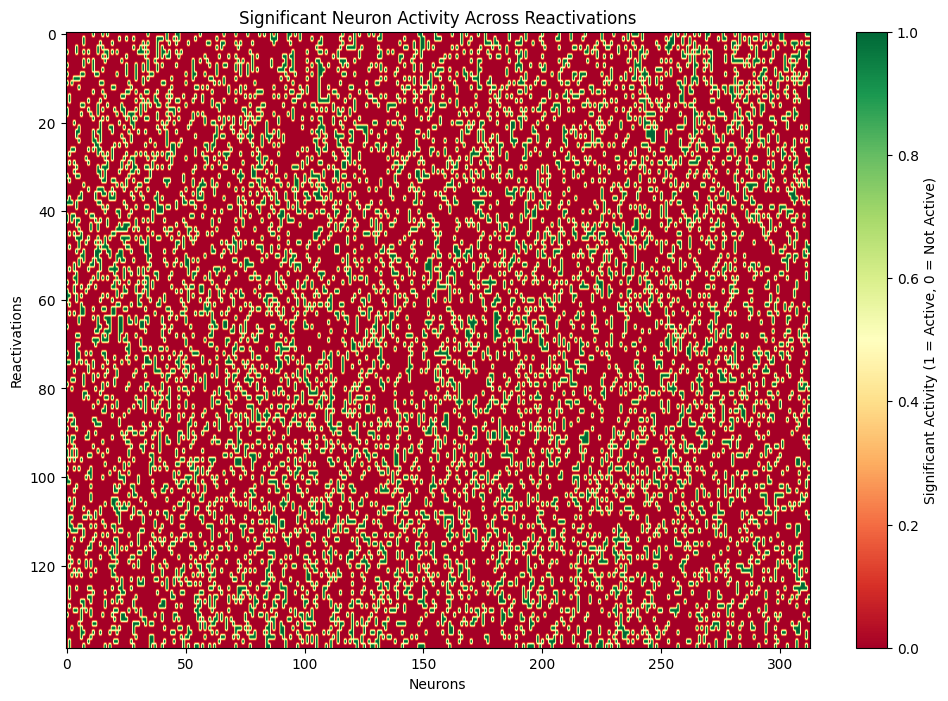

In [22]:
significant_neurons_list_r1_top_features = analyze_significant_neurons(mean_activity_r_1[:, top_features], trials=mean_activity_r_1.shape[0])
plot_significant_neurons(significant_neurons_list_r1_top_features, total_neurons=313)


In [51]:
print(mean_activity_cs_1.shape)
print(np.mean(mean_activity_cs_1, axis=0).shape)

(68, 3124)
(3124,)


In [52]:
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress, t

def compute_drift(mean_activity, confidence= .95):
    # Calculate absolute differences in activity from one trial to the next
    baseline = np.diff(np.mean(mean_activity, axis=1))
    absolute_differences = np.abs(np.diff(mean_activity, axis=0)-baseline) #(trials, neurons)

    # Calculate one number of activity change across all neurons (average change per trial)
    average_activity_change = np.mean(absolute_differences, axis=1) #/ np.abs(np.diff(np.mean(mean_activity, axis=1))) # Average across neurons for each trial

    # Printing the average activity change
    print("Average activity change across all neurons per trial:")
    print(average_activity_change)

        # Create x (trial indices) and y (cosine similarities)
    x = np.arange(len(average_activity_change)).reshape(-1, 1)
    y = np.array(average_activity_change)

        # Fit a linear regression model to find the trend
    reg_model = LinearRegression()
    reg_model.fit(x, y)
    y_trend = reg_model.predict(x)

    # Calculate slope and p-value using scipy.stats.linregress
    slope, intercept, r_value, p_value, std_err = linregress(x.flatten(), y)
    print(f"Slope: {slope}")
    print(f"P-value: {p_value}")

    if p_value < 0.05:
        print("The regression line significantly changes over time (p < 0.05).")
    else:
        print("The regression line does not significantly change over time (p >= 0.05).")
    
    # Calculate confidence intervals for the trend line
    n = len(y)
    dof = n - 2  # degrees of freedom
    t_crit = t.ppf((1 + confidence) / 2, dof)  # critical t-value for the given confidence level

    # Standard error of the predicted values
    residuals = y - y_trend
    s_err = np.sqrt(np.sum(residuals**2) / dof)

    # Compute the confidence interval
    ci = t_crit * s_err * np.sqrt(1 / n + (x.flatten() - np.mean(x.flatten()))**2 / np.sum((x.flatten() - np.mean(x.flatten()))**2))
    upper_bound = y_trend.flatten() + ci
    lower_bound = y_trend.flatten() - ci


    # Plot the average activity change per trial
    plt.figure(figsize=(10, 6))
    plt.plot(average_activity_change, marker='o', linestyle='-', color='blue')
    plt.plot(x.flatten(), y_trend, color="red", linestyle="--", linewidth=2, label= "Trend Line (linear)")
    plt.fill_between(x.flatten(), lower_bound, upper_bound, color="red", alpha=0.2, label=f"{int(confidence*100)}% confidence interval")
    plt.xlabel('Trial (t)')
    plt.ylabel('Average Absolute Activity Change')
    plt.title('Average Activity Change Across All Neurons per Trial')
    plt.grid(True)
    plt.show()

    return average_activity_change

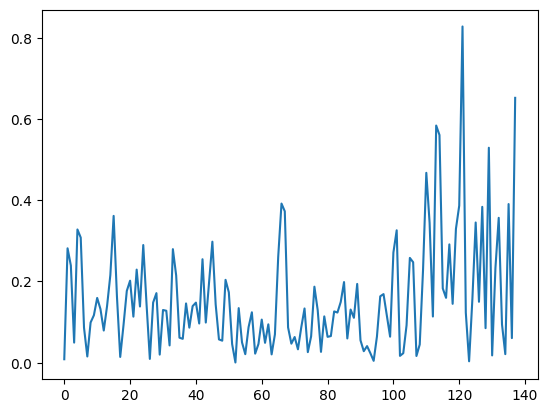

In [53]:
plt.plot(np.abs(np.diff(np.mean(mean_activity_r_1, axis=1)))) # Average across neurons for each trial


In [54]:
average_activity_change_cs_1 = compute_drift(mean_activity_cs_1)
average_activity_change_cs_2 = compute_drift(mean_activity_cs_2)
average_activity_change_r_1 = compute_drift(mean_activity_r_1)
average_activity_change_r_2 = compute_drift(mean_activity_r_2)

ValueError: operands could not be broadcast together with shapes (67,3124) (67,) 

[[1.08442445 1.01953178 1.1123456  ... 1.1807366  1.30437283 1.04579402]
 [0.75934961 1.24169282 2.19046784 ... 0.90347476 0.64327441 1.44527252]
 [0.84202109 1.25300043 1.75577468 ... 1.13190367 0.54193919 1.10176699]
 ...
 [0.70304186 0.         0.04679679 ... 0.37330171 0.77650955 0.63139444]
 [0.51839333 0.34023596 0.28719305 ... 1.52780989 1.1111708  1.83974053]
 [1.20454341 2.08097186 1.86682739 ... 0.77011246 2.04416333 0.93995404]]


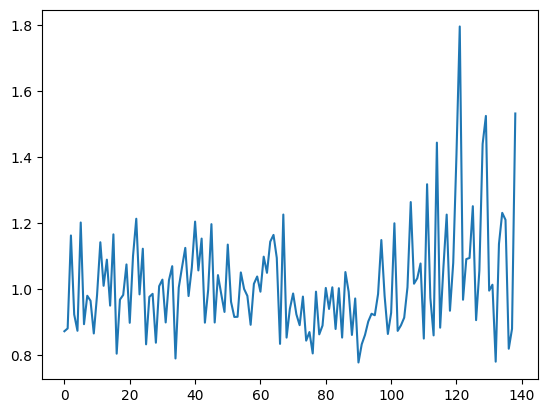

In [40]:
print(mean_activity_r_1)
plt.plot(np.mean(mean_activity_r_1, axis=1))

In [18]:
# Total trials (including the original 68 trials)
num_trials = mean_activity_cs_1.shape[0]

# Count reactivations per trial (1-based indexing)
unique_trials, counts = np.unique(trial_r_1, return_counts=True)

# Create an array for reactivations per trial, initialized with zeros
reactivations_per_trial = np.zeros(num_trials, dtype=int)

# Populate reactivations for the corresponding trials
reactivations_per_trial[unique_trials - 1] = counts  # Adjust 1-based to 0-based indexing

# Align with average_activity_change by excluding the first trial
aligned_reactivations = reactivations_per_trial[:-1]  # Exclude last trial

# Check that lengths now match
print(f"Length of average_activity_change: {len(average_activity_change_cs_1)}")
print(f"Length of aligned_reactivations: {len(aligned_reactivations)}")

# Debugging output
print("Aligned Reactivations:", aligned_reactivations)


Length of average_activity_change: 67
Length of aligned_reactivations: 67
Aligned Reactivations: [3 3 2 1 2 0 1 2 2 2 2 5 3 3 3 2 2 2 3 2 3 0 1 1 2 2 1 1 3 4 1 0 1 3 1 1 1
 1 2 2 2 2 1 2 2 1 1 1 0 1 1 3 2 3 4 1 4 5 3 2 3 4 2 3 6 4 0]


67 67
Pearson Correlation Coefficient: -0.05
P-value: 6.97e-01


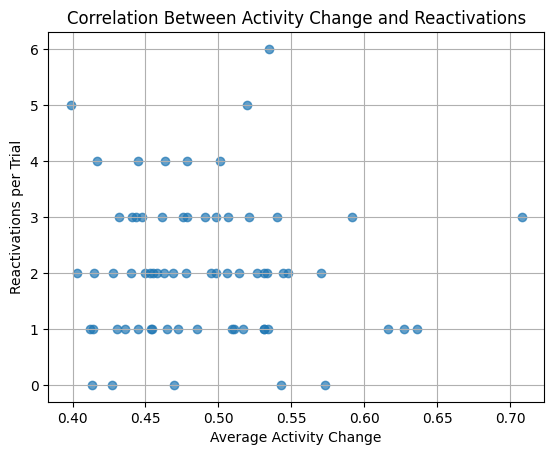

In [19]:
from scipy.stats import pearsonr

print(len(average_activity_change_cs_1), len(aligned_reactivations))

# Calculate Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(average_activity_change_cs_1, aligned_reactivations)

# Display results
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.2f}")
print(f"P-value: {p_value:.2e}")

# Optional: Visualize the relationship with a scatter plot
plt.scatter(average_activity_change_cs_1, aligned_reactivations, alpha=0.7)
plt.title("Correlation Between Activity Change and Reactivations")
plt.xlabel("Average Activity Change")
plt.ylabel("Reactivations per Trial")
plt.grid(True)
plt.show()


Activity Changes (Increased vs Decreased):
[[ 621 2503]
 [1683 1441]
 [1112 2012]
 [2140  984]
 [1000 2122]
 [1508 1616]
 [2136  988]
 [1165 1959]
 [1146 1978]
 [1595 1529]
 [1394 1730]
 [1490 1631]
 [1632 1492]
 [1832 1292]
 [1557 1567]
 [1675 1449]
 [1114 2010]
 [1990 1134]
 [1618 1505]
 [1160 1964]
 [1761 1363]
 [1946 1178]
 [1001 2123]
 [2122 1002]
 [ 867 2257]
 [1572 1552]
 [1770 1353]
 [1493 1629]
 [1251 1872]
 [1453 1671]
 [1619 1505]
 [1971 1153]
 [2054 1070]
 [1300 1822]
 [1860 1260]
 [ 942 2181]
 [1679 1442]
 [1505 1619]
 [2004 1119]
 [ 998 2126]
 [2169  955]
 [1064 2060]
 [1305 1819]
 [1444 1679]
 [2154  967]
 [1240 1883]
 [1218 1906]
 [1874 1250]
 [1613 1511]
 [1370 1753]
 [1984 1139]
 [1555 1568]
 [1262 1860]
 [1996 1127]
 [1566 1558]
 [1565 1559]
 [1463 1661]
 [1081 2042]
 [1669 1451]
 [2013 1111]
 [ 944 2180]
 [1991 1132]
 [1512 1611]
 [1929 1194]
 [1466 1658]
 [1350 1773]
 [1997 1127]]
Correlation (Neurons Increased vs Reactivations): -0.19, p-value: 1.16e-01
Correlatio

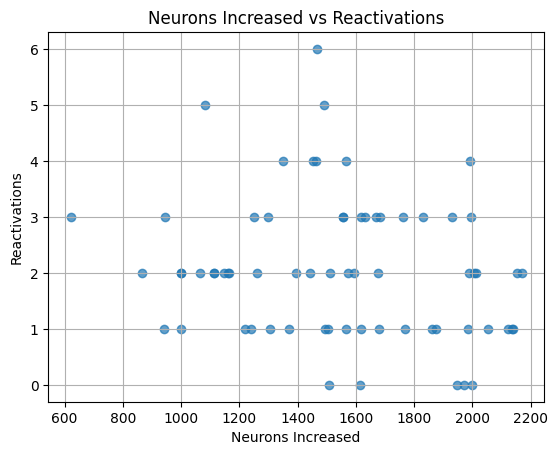

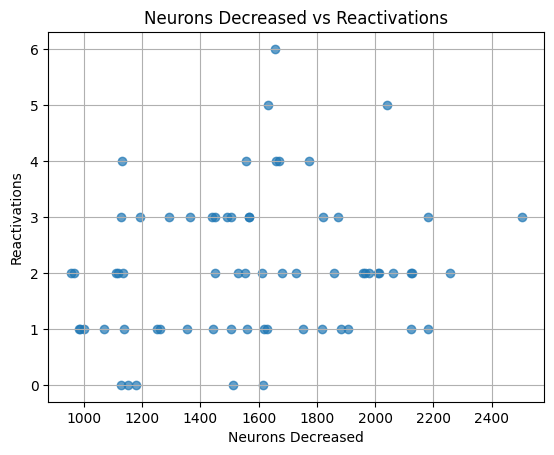

In [112]:
diffs = np.diff(mean_activity_cs_1, axis=0)
# Count increases and decreases for each trial pair
neurons_increased = np.sum(diffs > 0, axis=1)  # Number of neurons with increased activity
neurons_decreased = np.sum(diffs < 0, axis=1)  # Number of neurons with decreased activity

activity_changes = np.vstack((neurons_increased, neurons_decreased)).T

print("Activity Changes (Increased vs Decreased):")
print(activity_changes)

# Extract neurons increased and decreased activity
neurons_increased = activity_changes[:, 0]  # First column
neurons_decreased = activity_changes[:, 1]  # Second column

# Compute correlations
correlation_increased, p_value_increased = pearsonr(neurons_increased, aligned_reactivations)
correlation_decreased, p_value_decreased = pearsonr(neurons_decreased, aligned_reactivations)

# Print results
print(f"Correlation (Neurons Increased vs Reactivations): {correlation_increased:.2f}, p-value: {p_value_increased:.2e}")
print(f"Correlation (Neurons Decreased vs Reactivations): {correlation_decreased:.2f}, p-value: {p_value_decreased:.2e}")

plt.scatter(neurons_increased, aligned_reactivations, alpha=0.7)
plt.title("Neurons Increased vs Reactivations")
plt.xlabel("Neurons Increased")
plt.ylabel("Reactivations")
plt.grid(True)
plt.show()

plt.scatter(neurons_decreased, aligned_reactivations, alpha=0.7)
plt.title("Neurons Decreased vs Reactivations")
plt.xlabel("Neurons Decreased")
plt.ylabel("Reactivations")
plt.grid(True)
plt.show()

In [6]:
# Define baseline and early trial periods
baseline_trials = slice(0, 5)  # Baseline period (e.g., first 5 trials)
early_trials = slice(0, 20)    # Early learning period (first 20 trials)

# Compute average activity for baseline and early trials
mean_activity_cs1_baseline = mean_activity_cs_1[baseline_trials, :].mean(axis=0)
mean_activity_cs1_early = mean_activity_cs_1[early_trials, :].mean(axis=0)

mean_activity_cs2_baseline = mean_activity_cs_2[baseline_trials, :].mean(axis=0)
mean_activity_cs2_early = mean_activity_cs_2[early_trials, :].mean(axis=0)

# Compute relative change in activity
epsilon = 1e-8  # Small value to avoid division by zero
relative_change_cs_1 = (mean_activity_cs1_early - mean_activity_cs1_baseline) / (mean_activity_cs1_baseline + epsilon)
relative_change_cs_2 = (mean_activity_cs2_early - mean_activity_cs2_baseline) / (mean_activity_cs2_baseline + epsilon)

# Rank neurons by relative increase in activity
ranked_neurons_cs_1 = np.argsort(relative_change_cs_1)[::-1]  # Descending order for CS_1
ranked_neurons_cs_2 = np.argsort(relative_change_cs_2)[::-1]  # Descending order for CS_2

# Compute top 10% of neurons
num_neurons = mean_activity_cs_1.shape[1]
top10_per = int(num_neurons * 0.10)  # Top 10% of neurons

# Select top neurons with a positive relative change
top_neurons_cs_1 = ranked_neurons_cs_1[relative_change_cs_1[ranked_neurons_cs_1] > 0][:top10_per]
top_neurons_cs_2 = ranked_neurons_cs_2[relative_change_cs_2[ranked_neurons_cs_2] > 0][:top10_per]

# Combine top neurons across both conditions while maintaining order
all_top_neurons = np.concatenate((top_neurons_cs_1, top_neurons_cs_2))
unique_top_neurons, indices = np.unique(all_top_neurons, return_index=True)
top_neurons_learn = unique_top_neurons[np.argsort(indices)]  # Maintain original order

# Output
print(f"Top Neurons (Learning-Related, Ordered by Relative Increase in First 15 Trials): {top_neurons_learn}")


Top Neurons (Learning-Related, Ordered by Relative Increase in First 15 Trials): [ 207  159 2943 2569 2002 1095 2030 2589  754 2134 1812 1838 2456 2785
 1868 1142 2794 2488 2558  769    4 1028 1990  391 2426 1687  490  707
 1944 1298  336 1939  466 1918 2467  212 2343  607  921 2543 2636 2125
   26  440 3088  641 2461   42  268  789 2547 1647  922 2368 1698 1325
 2314  270 1717 3076 3045  806 2555 2618 1537  781 1432 2611 2581   25
  504 1351 1105 2784 3074 2612  569  296 2637 1273 1949 1756  122    0
 2093 3109 1565 2681  459 1895 2349 1153  953  283  642  726 1194  218
 1846 2091   29 2029 2103  680 2726 1615 2337 1009  998 1985   33  544
  494 1411 2409  519  530 2288  857  173 2257 2074 1578 2626 3113 3105
 1167 2477 1268 2736  874  113 3090   23 3082 2973 2827  841  181  144
 1039  126 1753 2389  509 1474  229 2779  763 2942 2959 2530 1212 1887
 1040  631 1977 2731 3055 1032 1572   15 3080  793 2775 2158 2219 2890
 2083 2995 2066 1216  235 1205   44 2278 2284 2410 1802  935 1074 2

# feature importance analysis

In [31]:
less_important_features = importance[importance <= .05]
print(len(less_important_features))
less_important_features = sorted_features[964:]


important_activity_cs = mean_activity_cs_1[:, top_features]
important_activity_r = mean_activity_r_1[:, top_features]

less_important_activity_cs = mean_activity_cs_1[:, less_important_features]
less_important_activity_r = mean_activity_r_1[:, less_important_features]

# Compute baseline activity (mean and std across all reactivation events per neuron)
baseline_mean = mean_activity_r_1.mean(axis=0)  # Baseline mean per neuron
baseline_std = mean_activity_r_1.std(axis=0)    # Baseline std per neuron

# Define threshold: baseline_mean + k * baseline_std
k = 2  # Set threshold multiplier
thresholds = baseline_mean + k * baseline_std  # Shape: (neurons,)

# Classify active neurons for each reactivation
reactivation_matrix = (mean_activity_r_1 > thresholds).astype(int)  # Binary matrix (1 = active, 0 = inactive)

# Output the reactivation matrix
print("Reactivation Matrix (Reactivations x Neurons):")
print(reactivation_matrix)

important_features = np.array(important_features, dtype=int)
less_important_features = np.array(less_important_features, dtype=int)


# Calculate reactivation rates (fraction of reactivations where neuron is active)
reactivation_rates = reactivation_matrix.sum(axis=0) / reactivation_matrix.shape[0]

important_reactivation_rates = reactivation_rates[important_features]
less_reactivation_rates = reactivation_rates[less_important_features]

important_baseline_activity = baseline_mean[important_features]
less_baseline_activity = baseline_mean[less_important_features]

important_drift = np.abs(np.diff(mean_activity_cs_1[:, important_features]))
less_drift = np.abs(np.diff(mean_activity_cs_1[:, less_important_features]))

print("Reactivation Rates (per neuron):")
print(reactivation_rates)


965
Reactivation Matrix (Reactivations x Neurons):
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]]
Reactivation Rates (per neuron):
[0.03597122 0.0647482  0.04316547 ... 0.05755396 0.02877698 0.03597122]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


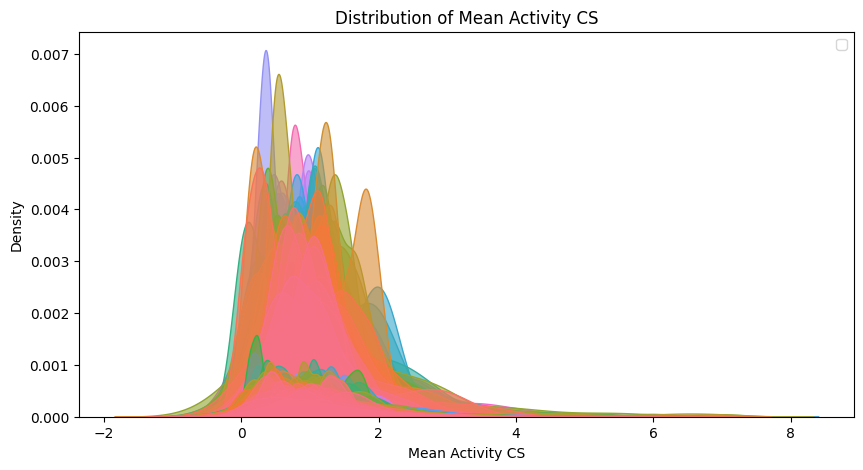

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


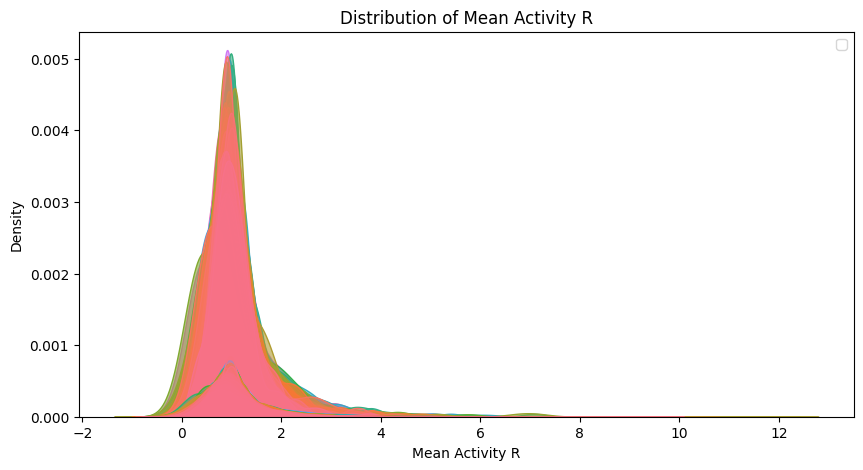

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


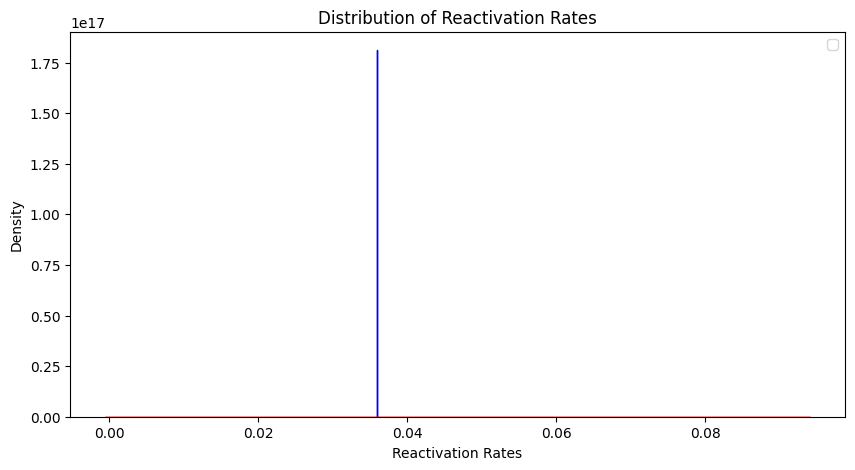

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


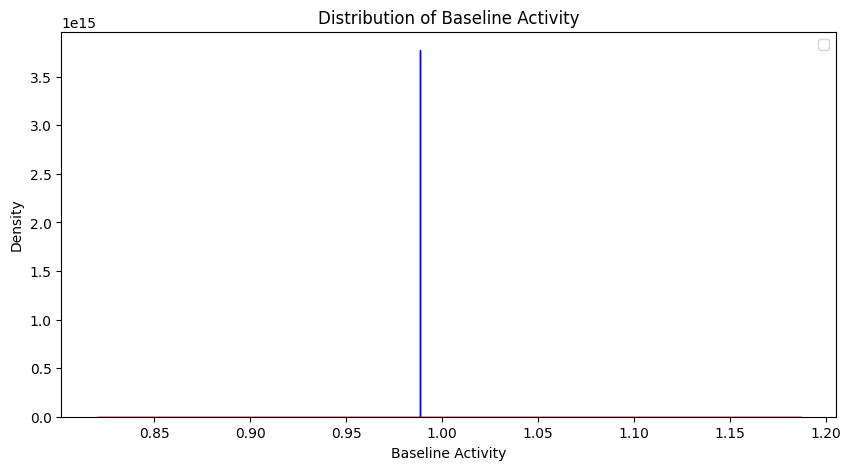

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


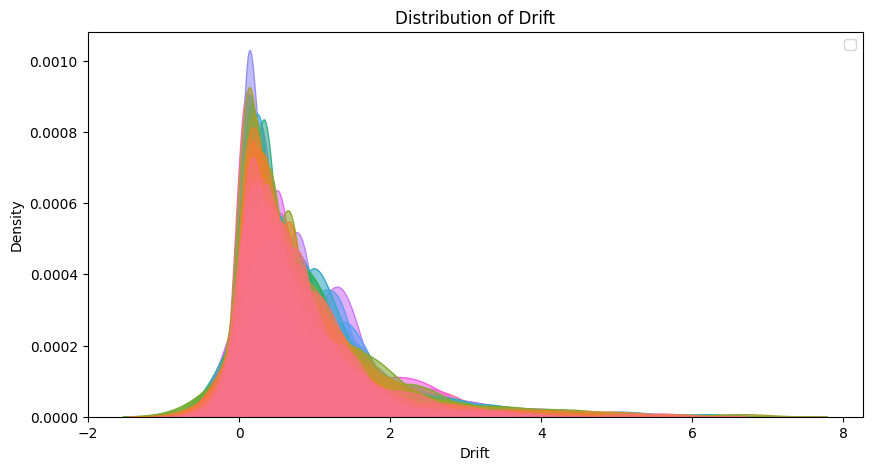

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


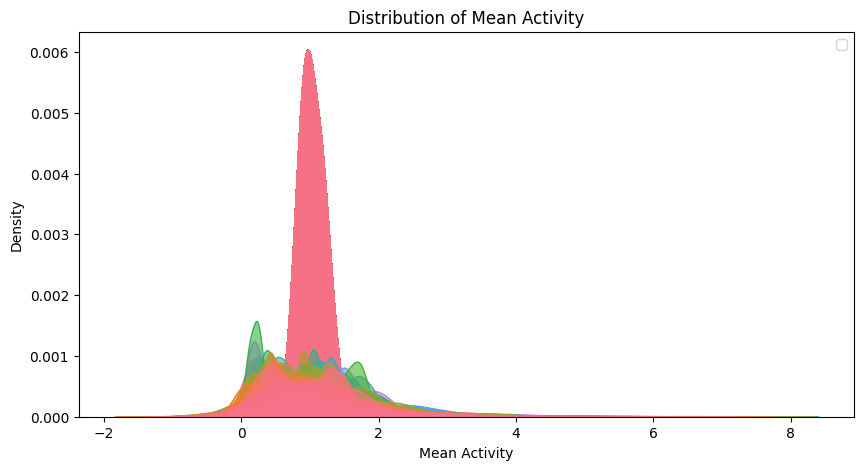

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


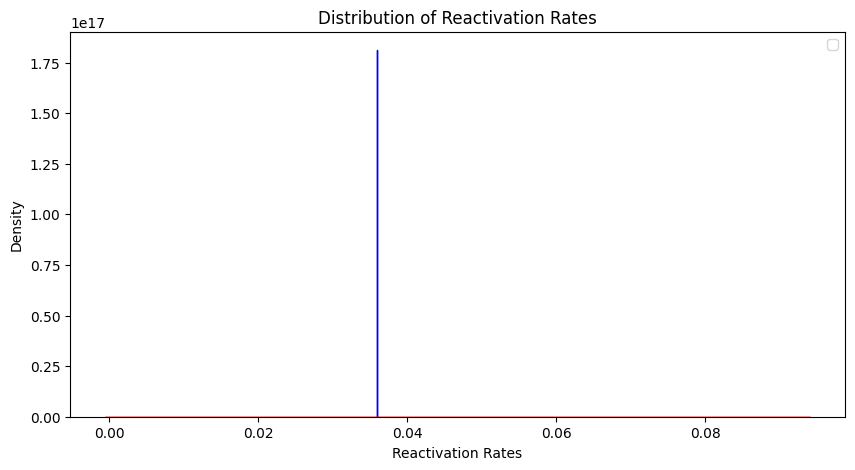

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


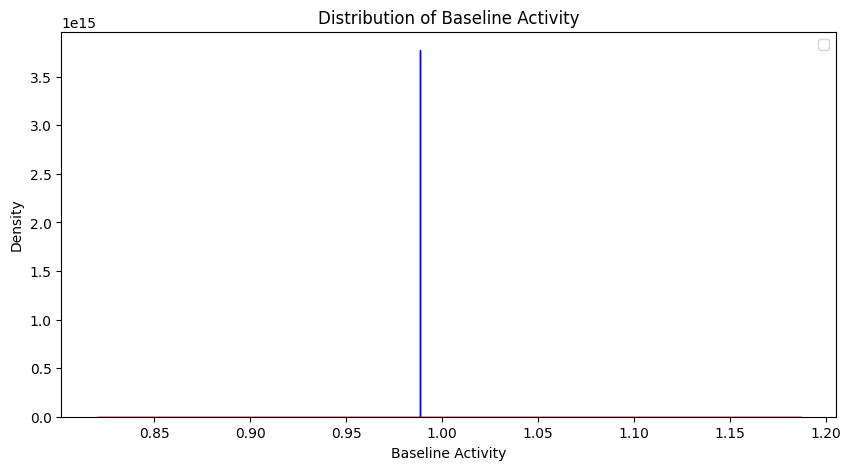

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


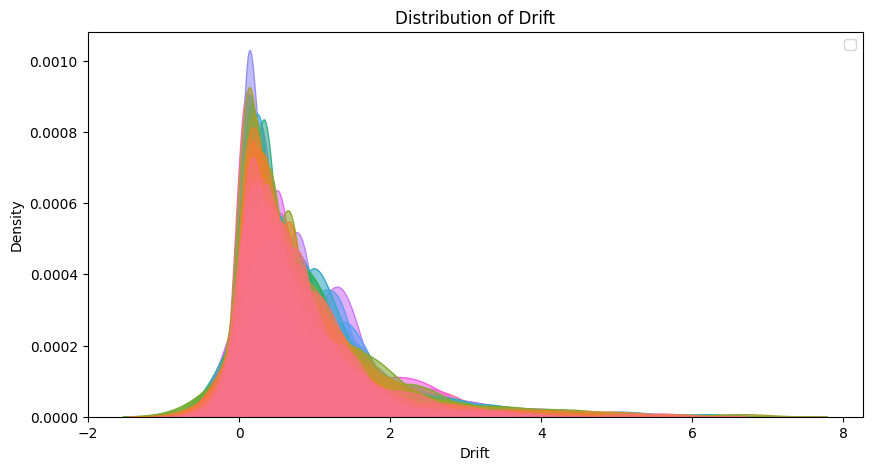

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Visualize distributions
properties = [
    ("Mean Activity CS", important_activity_cs, less_important_activity_cs),
    ("Mean Activity R", important_activity_r, less_important_activity_r),
    ("Reactivation Rates", important_reactivation_rates, less_reactivation_rates),
    ("Baseline Activity", important_baseline_activity, less_baseline_activity),
    ("Drift", important_drift, less_drift),
]

for property_name, important, less in properties:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(important, color="blue", fill=True, alpha=0.6)
    sns.kdeplot(less, color="red", fill=True, alpha=0.6)
    plt.title(f"Distribution of {property_name}")
    plt.xlabel(property_name)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Statistical test (t-test)
    #t_stat, p_value = ttest_ind(important, less, equal_var=False)
    #print(f"{property_name}: t-statistic = {t_stat:.2f}, p-value = {p_value:.3f}")


# Visualize distributions
properties = [
    ("Mean Activity", mean_activity_cs_1[:, important_features], mean_activity_cs_1[:, less_important_features]),
    ("Reactivation Rates", important_reactivation_rates, less_reactivation_rates),
    ("Baseline Activity", important_baseline_activity, less_baseline_activity),
    ("Drift", important_drift, less_drift),
]

for property_name, important, less in properties:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(important, color="blue", fill=True, alpha=0.6)
    sns.kdeplot(less, color="red", fill=True, alpha=0.6)
    plt.title(f"Distribution of {property_name}")
    plt.xlabel(property_name)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Statistical test (t-test)
    #t_stat, p_value = ttest_ind(important, less, equal_var=False)
    #print(f"{property_name}: t-statistic = {t_stat:.2f}, p-value = {p_value:.3f}")

